In [1]:
import os
os.environ['HTTP_PROXY'] = "http://127.0.0.1:10809"
os.environ['HTTPS_PROXY'] = "http://127.0.0.1:10809"

In [2]:
import geemap
import ee
Map=geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(T…

In [3]:
# 青海省部分地区
roi = ee.Geometry.Rectangle([90.102623, 34.677942,90.7077, 35.317184])
region = [90.102623, 34.677942,90.7077, 35.317184]
# roi = ee.Geometry.Rectangle([114.059, 30.2318,114.656, 30.8052])
# region = [114.059, 30.2318,114.656, 30.8052]
Map.addLayer(roi, {}, "roi")
Map.centerObject(roi,9)

In [4]:
# 去云、云阴影、雪掩膜函数
def maskL8sr(image):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 5)
    snowBitMask = (1 << 4)   
    qa = image.select('pixel_qa')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0) \
                   .And(qa.bitwiseAnd(cloudsBitMask).eq(0)) \
                   .And(qa.bitwiseAnd(snowBitMask).eq(0))
    return image.updateMask(mask)

# AWEI(自动水体提取指数): AWEIsh = B2 + 2.5B3 - 1.5(B5+B6) - 0.25B7
def water_index(image):
    ndvi=image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    mndwi=image.normalizedDifference(['B3', 'B6']).rename("mNDWI") 
    ndvi_mndwi = ndvi.subtract(mndwi).rename('ndvi_mndwi')
    awei = image.expression('B2 + 2.5*B3 - 1.5*(B5+B6) - 0.25*B7',
        {
          'B2': image.select('B2'),
          'B3': image.select('B3'),    
          'B5': image.select('B5'),    
          'B6': image.select('B6'),
          'B7': image.select('B7'),
        }).rename('AWEI')
    return image.addBands(ndvi_mndwi).addBands(ndvi).addBands(mndwi).addBands(awei)

visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

# 计算percentage

In [5]:
landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2018-12-31')

water_mask = water_index(landsat_images.map(maskL8sr).mosaic()).select('ndvi_mndwi').lt(0).clip(roi)
Map.addLayer(water_mask,{'palette':['white','blue'],'min':0,'max':1},"water mask")

validPixel = landsat_images.map(maskL8sr).count().select('B3').clip(roi).rename('count')
basemap = ee.Image.constant(0).clip(roi).rename('count')
validPixel = ee.ImageCollection([validPixel,basemap]).sum()
Map.addLayer(validPixel,{'palette':['white','#e40775'],'min':0,'max':63},"validPixel")

allPixel = landsat_images.count().select('B3').clip(roi).rename('count')
Map.addLayer(allPixel,{'palette':['white','green'],'min':0,'max':90},"all Pixel")

water_mask = water_index(landsat_images.map(maskL8sr).mosaic()).select('ndvi_mndwi').lt(0).clip(roi)
validPercent = validPixel.select('count').divide(allPixel.select('count')).updateMask(water_mask)
Map.addLayer(validPercent,{'palette':['blue','red'],'min':0,'max':1},"valid percent")

In [6]:
minmax = validPixel.updateMask(water_mask).reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

{'count_max': 34, 'count_min': 1}


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 26, 27, 28, 30, 30, 31, 32, 33, 34, 35, 36]
[10180, 69359.37254901958, 232266.39607843145, 292799.4235294118, 367153.1450980391, 281297.70196078427, 470271.0000000006, 156419.9411764706, 619994.8823529416, 456529.32941176486, 573643.2, 449975.25490196084, 316099.66666666674, 143637.06666666642, 89857.07058823529, 48858.87843137255, 56913.2274509804, 17828.415686274508, 43442.92941176469, 40062.117647058825, 52873.592156862745, 43763.54509803922, 67393.3960784314, 55143.70588235295, 142451.92549019615, 41256.78823529414, 62246.2627450981, 23809.235294117658, 46741.35686274512, 26048.313725490207, 5531.498039215687, 8353.7882352941, 8604.07058823527, 2676.847058823528, 1464.8470588235307, 210, 24.250980392156862]


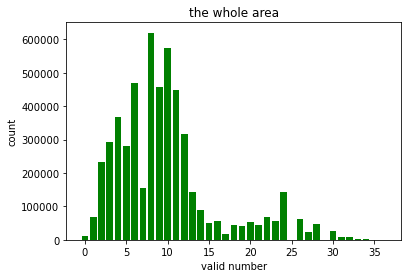

In [7]:
all_HistogramCount = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.histogram(100,1),
    'geometry': roi,
    'scale': 30,
})

x = ee.Array(ee.Dictionary(all_HistogramCount.get('count')).get('bucketMeans')).int().getInfo()
y = ee.Dictionary(all_HistogramCount.get('count')).get('histogram').getInfo()
print(x)
print(y)

# -*- coding: utf-8 -*-
import numpy as np  
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt   
fig = plt.figure()
plt.bar(x,y,0.8,color="green")
plt.xlabel("valid number")
plt.ylabel("count")
plt.title("the whole area")

plt.show()  
# plt.savefig("barChart.jpg")

In [ ]:
water_HistogramCount = validPixel.updateMask(water_mask).reduceRegion(**{
    'reducer': ee.Reducer.histogram(100,1),
    'geometry': roi,
    'scale': 30,
})

water_x = ee.Array(ee.Dictionary(water_HistogramCount.get('count')).get('bucketMeans')).int().getInfo()
water_y = ee.Dictionary(water_HistogramCount.get('count')).get('histogram').getInfo()
print(water_x)
print(water_y)

# -*- coding: utf-8 -*-
import numpy as np  
import matplotlib.mlab as mlab  
import matplotlib.pyplot as plt   
fig = plt.figure()
plt.bar(water_x,water_y,0.8,color="green")
plt.xlabel("valid number")
plt.ylabel("count")
plt.title("the water area")

plt.show()  

In [ ]:
minmax = validPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
minmax = allPixel.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
minmax = validPercent.reduceRegion(**{
    'reducer': ee.Reducer.minMax(),
    'geometry': roi,
    'scale': 30,
    'maxPixels': 1e14,
})
print(minmax.getInfo())

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
visParams = {
  'min': 0.0,
  'max': 35.0,
  'palette': ['FFFFFF','0000FF'],
}
ax = cartoee.get_map(validPixel,region=region,vis_params=visParams)
cartoee.add_colorbar(ax, vis_params=visParams,loc="right",label="number", orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
ax.set_title(label = 'valid Pixel in 2018', fontsize=14)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
visParams = {
  'min': 0.0,
  'max': 50.0,
  'palette': ['FFFFFF','FF0000'],
}
ax = cartoee.get_map(allPixel,region=region,vis_params=visParams)
cartoee.add_colorbar(ax, vis_params=visParams,loc="right",label="number", orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
ax.set_title(label = 'all Pixel in 2018', fontsize=14)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
visParams = {
  'min': 0.0,
  'max': 1.0,
  'palette': ['FF0000','0000FF'],
}
ax = cartoee.get_map(validPercent,region=region,vis_params=visParams)
cartoee.add_colorbar(ax, vis_params=visParams,loc="right",label="percentage", orientation="vertical")
cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
ax.set_title(label = 'valid percentage in 2018', fontsize=14)

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib
from geemap import cartoee
visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}
fig = plt.figure(figsize=(12, 8))
ax = cartoee.get_map(landsat_images.map(maskL8sr).mosaic(), region=region, vis_params=visParams)
cartoee.add_gridlines(ax, interval=[0.1,0.1], linestyle=":")
ax.set_title(label = 'landsat8 image in 2018', fontsize=20)

# 制作gif

In [ ]:
visParams = {
    'bands': ['B5', 'B6', 'B4'],
    'min': 0,
    'max': 3000,
    'gamma': 1.4,
}

landsat_images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate('2018-01-01', '2018-12-31') \
    .sort('system:time_start')
rgbVis = landsat_images.map(lambda x:x.visualize(**visParams).clip(roi))

gifParams = {
  'region': roi,
  'dimensions': 600,
  'crs': 'EPSG:3857',
  'framesPerSecond': 1
}

geemap.download_ee_video(rgbVis,gifParams,'Qinghai_Province.gif')

In [ ]:
in_gif = os.path.abspath('../gee/Qinghai_Province.gif')
out_gif = os.path.join(os.path.expanduser('~'), 'Downloads/output2.gif')
dates = landsat_images.aggregate_array('system:time_start').sort().map(lambda d: ee.Date(d).format('YYYY-MM-dd')).getInfo()

geemap.add_text_to_gif(in_gif, out_gif, xy=('2%', '4%'), text_sequence=dates, font_size=25, font_color='red',duration=1000,)
geemap.add_text_to_gif(out_gif, out_gif, xy=('33%', '4%'), text_sequence='Part of Qinghai Province',font_size=27, font_color='red',duration=1100,progress_bar_color='red')

In [ ]:
geemap.show_image(out_gif)